<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/Tent_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Referenced Materials**

* https://amaarora.github.io/2020/09/13/unet.html
* https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
* https://www.youtube.com/watch?v=IHq1t7NxS8k

The majority of this comes from the referenced YouTube video

# Imports and Initialization

In [2]:
# Imports
!pip install segmentation-models-pytorch -q
!pip install -U albumentations -q

import sys
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import csv
import random
import matplotlib.patches as mpatches
import torch
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from glob import glob
import pickle
import shutil

     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 376 kB 23.8 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 102 kB 5.7 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 


In [3]:
# Initialize Environment
%env SRC_DIR       = sarpol-zahab-tents/
%env DATA_DIR      = data/
%env TRAIN_IMG_DIR = data/train_images/
%env TRAIN_LBL_DIR = data/train_labels/
%env VAL_IMG_DIR   = data/val_images/
%env VAL_LBL_DIR   = data/val_labels/
# %env PREDICT_DIR   = predictions/
%env OUTPUT_DIR    = output/
# %env OUTPUT_MASK_DIR    = output/mask/
# %env OUTPUT_DATA_DIR    = output/data/

SRC_DIR       = os.environ.get("SRC_DIR")
DATA_DIR      = os.environ.get("DATA_DIR")
TRAIN_IMG_DIR = os.environ.get("TRAIN_IMG_DIR")
TRAIN_LBL_DIR = os.environ.get("TRAIN_LBL_DIR")
VAL_IMG_DIR   = os.environ.get("VAL_IMG_DIR")
VAL_LBL_DIR   = os.environ.get("VAL_LBL_DIR")
# PREDICT_DIR   = os.environ.get("PREDICT_DIR")
OUTPUT_DIR    = os.environ.get("OUTPUT_DIR")
# OUTPUT_MASK_DIR    = os.environ.get("OUTPUT_MASK_DIR")
# OUTPUT_DATA_DIR    = os.environ.get("OUTPUT_DATA_DIR")

env: SRC_DIR=sarpol-zahab-tents/
env: DATA_DIR=data/
env: TRAIN_IMG_DIR=data/train_images/
env: TRAIN_LBL_DIR=data/train_labels/
env: VAL_IMG_DIR=data/val_images/
env: VAL_LBL_DIR=data/val_labels/
env: OUTPUT_DIR=output/


In [4]:
# Initialize Directories
%%bash
echo "Working in Directory: $(pwd)"

if [ -d 'sample_data' ]; then
  rm -r sample_data
fi

if [ ! -d $SRC_DIR ]; then
 git clone https://github.com/tofighi/sarpol-zahab-tents.git
fi

if [ ! -d $DATA_DIR ]; then
  mkdir -p $DATA_DIR
  cp $SRC_DIR/data/sarpol_counts.csv $DATA_DIR
fi

if [ ! -d $TRAIN_IMG_DIR ]; then
  mkdir -p $TRAIN_IMG_DIR
fi

if [ ! -d $TRAIN_LBL_DIR ]; then
  mkdir -p $TRAIN_LBL_DIR
fi

if [ ! -d $VAL_IMG_DIR ]; then
  mkdir -p $VAL_IMG_DIR
fi

if [ ! -d $VAL_LBL_DIR ]; then
  mkdir -p $VAL_LBL_DIR
fi

# if [ ! -d $PREDICT_DIR ]; then
#   mkdir -p $PREDICT_DIR
# fi

# if [ ! -d $OUTPUT_MASK_DIR ]; then
#   mkdir -p $OUTPUT_MASK_DIR
# fi

# if [ ! -d $OUTPUT_DATA_DIR ]; then
#   mkdir -p $OUTPUT_DATA_DIR
# fi

Working in Directory: /content


Cloning into 'sarpol-zahab-tents'...


# Configuration

In [5]:
# Configuration
# Dataset
TEST_SIZE = 0.3
RANDOM_STATE = 123
ALLOW_IRRELEVANT = False # If images don't have tents do we want to throw them out or not?
SARPOL = False # do we want to download the very large Sarpol image?

GRAYSCALE = False # Print tents as grayscale or not



# TODO: lets just load all data as validation data to generate the map data and such



TENT_CSV          = f"{DATA_DIR}sarpol_counts.csv"
LOAD_FROM_CSV = True

BLOB_LOCALIZATION = False
KMEANS_LOCALIZATION = True

# Display Limit
DISP_LIMIT    = 1 # Maximum number of images to display
DISP_RESULTS  = True
DISP_SCALE    = 2#150 # Amount to integer divide displayed figure scale by (set to 1 to disable); useful if the notebook keeps crashing

# Images
IMG_FORMAT    = "png"
BRIGHTNESS    = 0.5 # set to 1 for no dimming

# Checkpoints
CHECKPOINT    = "checkpoint.pt"

# Hyperparameters
LEARNING_RATE = 1e-4 # 1x10^-4 = 0.0001
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE    = 1#5 # Batch size defines the prediction batch; set to 1 if we want individual files
NUM_EPOCHS    = 50 #100
NUM_WORKERS   = 2
IMAGE_HEIGHT  = 512
IMAGE_WIDTH   = 512
PIN_MEMORY    = True
LOAD_MODEL    = True

# Convolution Settings
C_KERNEL      = 3     # This is the matrix that slides across the image (we define matrix size, so kernel = 3 means 3x3 matrix that slides across the image)
C_STRIDE      = 1     # Number of pixels the kernel slides over the input (how many pixels we move the filter at a time)
C_PADDING     = 1     # Sometimes the filter doesn't perfectly fit the input image, in which case we can pad with 0s or drop the part of the image that didn't fit (called valid padding)
C_BIAS        = False # Bias is false in this case because we're using BatchNorm2d (bias would be canceled by the batch norm, so we set it to false)
R_INPLACE     = True  #

# UNet Settings
IN_CHANNELS   = 3
OUT_CHANNELS  = 1 # We're doing binary image segmentation (because our masks are black and white), so we can output a single channel
U_FEATURES    = [64, 128, 256, 512] # Features come from the architecture (the number above the boxes)

# UNet Pool Settings
P_KERNEL      = 2
P_STRIDE      = 2

# Final layer kernel size
F_KERNEL      = 1 # Because we're outputting the final image here



# Accuracy; this is used to prevent division by zero, so we want a small value that doesn't have much impact on the results
EPSILON = sys.float_info.epsilon

In [6]:
# def load_dataset(path):
#   dataset = {}
#   for path in sorted(glob(path)):
#     mask = np.asarray(Image.open(path).convert('1'))
#     if ALLOW_IRRELEVANT:
#       dataset[os.path.basename(path).split(f".", 1)[0]] = mask
#     elif np.sum(mask):
#       dataset[os.path.basename(path).split(f".", 1)[0]] = mask
#   return dataset





# TODO: make this use a dictionary instead, since that'll make it easier to get the image we want
def load(path):
  return np.array([(np.asarray(Image.open(path)), os.path.basename(path).split(f".", 1)[0]) for path in sorted(glob(path))])
  
MAP = None
if SARPOL:
  !gdown --id 1-YUbFjwFL2G5r8TudKS0XK56BjJ0KsTK
  MAP = load("sarpol.png")[0][0]
  print(f"Sarpol Shape: {MAP.shape}\n")

if LOAD_MODEL:
  !gdown --id 1ulHrgSyNwo1X2WYmQyeb4lIxIIJ4Xs-G

Downloading...
From: https://drive.google.com/uc?id=1ulHrgSyNwo1X2WYmQyeb4lIxIIJ4Xs-G
To: /content/checkpoint.pt
100% 373M/373M [00:06<00:00, 61.0MB/s]


# Preprocessing

In [7]:
# Preparing Data
# csv_src = f"{SRC_DIR}data/sarpol_counts.csv"
# if os.path.exists(csv_src):
#   tent_counts = []
#   with open(csv_src) as csvfile:
#     for row in csv.reader(csvfile):
#       tent_counts.append([int(row[1])])

#   with open(TENT_CSV, 'w') as csvfile:
#     csv.writer(csvfile).writerows(tent_counts)





# TODO: ragged array problem somewhere here


src_imgs = load(f"{SRC_DIR}data/images/*")
src_lbls = load(f"{SRC_DIR}data/labels/*")

dataset = []
# Dataset Structure:
# [
#   0:{
#     img:  image
#     lbl:  label
#     filename: {img: 0.png, lbl: 0.png}
#   },
#   1:{}, 2:{}, n:{}
# ]

if src_imgs.shape[0] == src_lbls.shape[0]:
  n = src_lbls.shape[0]

  for index in range(n):
    dataset.append({
      "img":Image.fromarray(src_imgs[index][0]),
      "lbl":Image.fromarray(src_lbls[index][0]),
      "filename":{
        "img":f"{src_imgs[index][1]}.{IMG_FORMAT}",
        "lbl":f"{src_lbls[index][1]}.{IMG_FORMAT}"
      }
    })

def save_data(data, val=False):
  img_dir = TRAIN_IMG_DIR
  lbl_dir = TRAIN_LBL_DIR

  if val:
    img_dir = VAL_IMG_DIR
    lbl_dir = VAL_LBL_DIR

  data["img"].save(f"{img_dir}/{data['filename']['img']}")
  data["lbl"].save(f"{lbl_dir}/{data['filename']['lbl']}")

relevant = 0
irrelevant = 0
for data in dataset:
  if np.asarray(data["lbl"]).sum() > 0:
    relevant += 1
  else:
    irrelevant += 1

def percent(sample, total):
  return f"({sample}/{total}) = {((sample/total)*100):.2f}%"

total = len(dataset)
print(f"Dataset Size: {total}\nRelevant Percentage: {percent(relevant, total)}, Irrelevant Percentage: {percent(irrelevant, total)}")
print(f"Allow Irrelevant Data? {'YES' if ALLOW_IRRELEVANT else 'NO'}")

training_set, validation_set = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE)

training_data = 0
for training in training_set:
  if ALLOW_IRRELEVANT or np.asarray(training["lbl"]).sum() > 0:
    save_data(training, val=False)
    training_data += 1
    
validation_data = 0
for testing in validation_set:
  if ALLOW_IRRELEVANT or np.asarray(testing["lbl"]).sum() > 0:
    save_data(testing, val=True)
    validation_data += 1


total_usable = training_data + validation_data
print(f"\nTraining Percentage: {percent(training_data, total_usable)}, Validation Percent: {percent(validation_data, total_usable)}")



# TODO: need to generate augmented data too (or at least ensure augmented data expands the dataset and doesn't just replace it), and also re-train the model on the updated version

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Dataset Size: 256
Relevant Percentage: (90/256) = 35.16%, Irrelevant Percentage: (166/256) = 64.84%
Allow Irrelevant Data? NO

Training Percentage: (62/90) = 68.89%, Validation Percent: (28/90) = 31.11%


In [8]:
# Cleanup
%%bash
if [ -d $SRC_DIR ]; then
  rm -r $SRC_DIR
fi

# UNet

**U-Net Architecture:**

The first half of the architecture is the down-sampling process. At each stage, two 3x3 convolutions are used. The output is then pooled and becomes the input for the next 3x3 convolution and so on, until the bottom of this diagram is reached.

The second half of the architecture is the up-sampling process, which is a reflection of the down-sampling process.

In [9]:
# UNet Model
# Adapted From https://www.youtube.com/watch?v=IHq1t7NxS8k
# Referenced https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential (
        nn.Conv2d(in_channels, out_channels, C_KERNEL, C_STRIDE, C_PADDING, bias=C_BIAS), # This is a same convolution (input height*width = output height*width)
        nn.BatchNorm2d(out_channels), # BatchNorm accelerates training by normalizing inputs by re-centering and re-scaling
        nn.ReLU(inplace=R_INPLACE), # ReLU is Rectified Linear Unit; essentially it makes it so negative inputs are discarded and positive inputs are passed through

        # Now we do this a second time but with out_channels to out_channels
        nn.Conv2d(out_channels, out_channels, C_KERNEL, C_STRIDE, C_PADDING, bias=C_BIAS),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=R_INPLACE),
    )

  def forward(self, x):
    return self.conv(x)

# DoubleConv is everything in the first node of the architecture (before pooling)

class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=U_FEATURES):
    super(UNet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList() # Stores the convolutional layers; it's a list, but using ModuleList lets us use BatchNorm2d
    self.pool = nn.MaxPool2d(kernel_size=P_KERNEL, stride=P_STRIDE) # Pooling layer will be used inbetween, in forwarding method
    # Note that the pooling layer will require out inputs to be perfectly divisible by 2 because we're doing a stride of 2
    # Example: 161 x 161 -> MaxPool -> 80 x 80 -> Upsample -> 160 x 160; in this case, we couldn't concatinate the two as they need the same width and height for concat (161x161 is input, 160x160 is output)
    # If input is perfectly dividible by 16 then this issue won't happen (16 because its 4 steps, all dividing by 2 (16/(4*2) = 2))
    # In order to keep the system general, we can either pad the image or crop the image so that it works even if image size isn't perfectly divisible by 16


    # Down-Sampling part of UNet
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature)) # Mapping some input (in the UNet architecture example, it maps 1 to 64 for the first node)
      in_channels = feature

    # Up-Sampling Part of UNet
    # At 10:20 or so in the video he mentions transposed convoltions that may be a better method to this part, but we'll use similar approach to UNet paper for now
    # We're using the reversed list of features because we're going from the bottom up now
    for feature in reversed(features):
      
      # In_channels is feature*2 here, output is feature
      self.ups.append(
          nn.ConvTranspose2d( 
              feature*2, feature, kernel_size=P_KERNEL, stride=P_STRIDE
          )
      )
      self.ups.append(DoubleConv(feature*2, feature)) # Because we go up then do two convs then go up then do two convs etc

    # Bottom Layer
    self.bottleneck = DoubleConv(features[-1], features[-1]*2) # We're using features[-1] because we want the bottom feature

    # Now we do 1x1 conv which doesn't change height or width just number of channels
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=F_KERNEL)
  

  def forward(self, x):
    skip_connections = [] # We skip connections for each stage in the architecture, as we use this part later on
    
    # This loop does all the down-sampling steps until the final step just before the bottom layer (aka bottleneck)
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1] # we wanna go backwards in order when we're doing our concatination; the highest resolution image is the first one; to make things easier, we'll just reverse this list

    # We're using a step of 2 here because we're going up then double conv each iteration
    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x) # doing ConvTranspose2d here
      skip_connection = skip_connections[i//2] # // is integer division; we're doing a step of one ordering here

      # Dealing with images that are not perfectly dividible
      # TODO: perhaps we should look into scaling instead of cropping or padding, or perhaps we should scale before we put the image into the system, so that this is not relevant?
      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connections.shape[2:]) # we're taking out height and width here; basically, we're resizing the image if it doesn't fit

      concat_skip = torch.cat((skip_connection, x), dim=1) # dim 1 is the channel dimension; we're concationating these things along the channel dimension
      x = self.ups[i+1](concat_skip) # running it through a double conv
    
    return self.final_conv(x)




# Testing the implementation thus far
def test():
  x = torch.randn((3, 1, 160, 160)) # 3 is number of images (batch size), 1 is number of channels, 160 is image height, 160 is image width
  model = UNet(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == "__main__":
   test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


# Dataset

In [10]:
# TentDataset
# Adapted From https://www.youtube.com/watch?v=IHq1t7NxS8k

# Data directory should be in the format:
# data
#   train_images
#   train_masks
#   val_images
#   val_masks


# TODO: probably needs to be able to support the case where the target is none?

class TentDataset(Dataset):
  def __init__(self, image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_LBL_DIR, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # We use L since mask is grey scale
    mask[mask == 255.0] = 1.0 # Preprocessing; we change this cuz we're using a sigmoid on the last activation for probability of white pixel, so this makes it work better?

    id = os.path.basename(image_path).replace(f".{IMG_FORMAT}", "")

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask, id

# Utilities

In [20]:
# Utilities
def dirs(root=OUTPUT_DIR):
  datasets = ["validation", "training"]
  dirs = {}
  for dataset in datasets:
    dataset_dir = f"{root}{dataset}/"
    dirs[dataset] = {"features":       f"{dataset_dir}features/",
                     "targets":        f"{dataset_dir}targets/",
                     "estimates":      f"{dataset_dir}estimates/",
                     "visualizations": f"{dataset_dir}visualizations/"}
  return dirs

DIRECTORIES = dirs()

for dataset in DIRECTORIES.values():
  for dir in dataset.values():
    if not os.path.exists(dir):
      os.makedirs(dir)


















def stitch(path):

  # imgs = load(f"{path}*") # TODO: need to make sure this is sorted by id
  imgs = np.array([np.asarray(Image.open(path)) for path in sorted(glob(path))])

  rows = imgs.size//2
  

  imgs = np.reshape(imgs, (rows, -1))

  print(imgs)

  return cv2.vconcat([cv2.hconcat(img) for img in imgs])




  # count = imgs.size
  # width = IMAGE_WIDTH * count #imgs[0][0].shape[0] * count
  # height = IMAGE_HEIGHT * count #imgs[0][0].shape[1] * count

  # TODO: need to know the row length

  #n_rows = count // 2 # since this is a square image?





  # row = []
  # columns = []

  # r_index = 0
  # i_index = 0
  # for img in imgs:
  #   if i_index < 1:
  #     row.append(img)
  #     i_index += 1
  #   else:
  #     columns.append(cv2.hconcat(row))
  #     # row = []
  #     r_index += 1
  #     i_index = 0

  # result = cv2.vconcat(columns)
  # result = cv2.hconcat(row)

  # print(result)

  
  # map = Image.new('RGB', (width, height))
  # for index, img_id in enumerate(imgs):
  #   img = img_id[0]
  #   id = img_id[1]
  #   numeric_id = int(id.split(f"_", 1)[1])

  #   cv2.hconcat()


    # map.paste(im=img, box=(width*(index),height*(index)))
  



    #index > 0 and int(imgs[index-1][1].split(f"_", 1)[1])+1 == numeric_id:
      # make sure this image is next before we stitch it in
      
      
  # return result



# If we want to use kmeans to count number of tents in the binary mask, we
# can just find out the number of pixels in a given dot, then get the total number
# of white pixels in the scene and divide by that number?

def kmeans_localize(img, k):
  img = np.argwhere(img.T == 255)
  centers = None
  if k > 0:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(img)
    y_kmeans = kmeans.predict(img)
    centers = kmeans.cluster_centers_
  return centers

def blob_localize(mask):
  params = cv2.SimpleBlobDetector_Params()
  params.minArea = 1;
  params.maxArea = IMAGE_HEIGHT * IMAGE_WIDTH;
  params.minDistBetweenBlobs = 0
  params.filterByColor = True
  params.filterByArea = True
  params.filterByCircularity = False
  params.filterByInertia = False
  params.filterByConvexity = False
  params.minThreshold = 0
  params.maxThreshold = 255
  params.blobColor = 255
  detector = cv2.SimpleBlobDetector_create(params)
  detector.empty()
  return detector.detect(mask)

def load_csv(id):
  with open(TENT_CSV) as csvfile:
    for row in list(csv.reader(csvfile)):
      if row[0].split(".", 1)[0] == id:
        return int(row[1])
  return None

# def visualize_old(image_data):
#   print("Displaying results. Please wait, this may take some time...")
#   for resolution in image_data: # This will only run once, since we only use one resolution
#     cols = 3
#     rows = len(image_data[resolution])

#     fig = plt.figure(figsize=(resolution[0]//DISP_SCALE, resolution[1]//DISP_SCALE)) # The figure needs to be big enough to accomodate all the images; maybe we need to get resolution elsewhere?
#     grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.5)

#     g_index = -1

#     for record in image_data[resolution]:
#       id = record["id"]
#       img = record["img"]
#       lbl = cv2.threshold(cv2.convertScaleAbs(cv2.cvtColor(record["lbl"], cv2.COLOR_BGR2GRAY)), 1, 255, cv2.THRESH_BINARY)[1]
#       prd = cv2.normalize(cv2.convertScaleAbs(cv2.cvtColor(record["prd"], cv2.COLOR_BGR2GRAY)), np.zeros(img.shape, dtype=np.float32), 0, 255, cv2.NORM_MINMAX)
      
#       if BLOB_LOCALIZATION:
#         lbl_keypoints = blob_localize(lbl)
#         prd_keypoints = blob_localize(prd)

#         lbl_points = []
#         prd_points = []

#         for point in lbl_keypoints:
#           lbl_points.append(np.array([point.pt[0], point.pt[1]]))

#         for point in prd_keypoints:
#           prd_points.append(np.array([point.pt[0], point.pt[1]]))

#         lbl_points = np.array(lbl_points)
#         prd_points = np.array(prd_points)

#       if LOAD_FROM_CSV:
#         lbl_count = load_csv(id) # TODO: need to get picture ID somehow
#         if lbl_count is not None and KMEANS_LOCALIZATION:
#           lbl_kmeans = kmeans_localize(lbl, lbl_count)

#       overlay = np.zeros(img.shape)
#       gt_overlay = np.zeros(img.shape)

#       if BLOB_LOCALIZATION:
#         mask_with_keypoints = np.zeros(img.shape)
#         mask_with_keypoints = cv2.drawKeypoints(prd, prd_keypoints, mask_with_keypoints, (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#       else:
#         mask_with_keypoints = prd
        
#       # Adapted from: https://stackoverflow.com/questions/46103731/is-there-a-simple-method-to-highlight-the-mask
#       contours, hierarchy = cv2.findContours(prd, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#       gt_contours, gt_hierarchy = cv2.findContours(lbl, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      
#       cv2.drawContours(overlay, contours, -1, (1, 0, 0), thickness=cv2.FILLED)
#       cv2.drawContours(gt_overlay, gt_contours, -1, (1, 0, 1), thickness=cv2.FILLED)

#       bg = (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if GRAYSCALE else img)
#       if GRAYSCALE:
#         bg = cv2.cvtColor(bg, cv2.COLOR_GRAY2BGR)
      
#       overlay = overlay.astype(np.float32)
#       gt_overlay = gt_overlay.astype(np.float32)
#       overlay = cv2.bitwise_xor(bg, overlay)
#       gt_overlay = cv2.bitwise_xor(bg, gt_overlay)
#       overlay = cv2.normalize(overlay, np.zeros(img.shape, dtype=np.uint8), 0, 1, cv2.NORM_MINMAX)
#       gt_overlay = cv2.normalize(gt_overlay, np.zeros(img.shape, dtype=np.uint8), 0, 1, cv2.NORM_MINMAX)

#       # Saving Data
#       # Image.fromarray(prd).save(f"{OUTPUT_MASK_DIR}{id}.{IMG_FORMAT}")
#       # Image.fromarray(overlay).save(f"{OUTPUT_DATA_DIR}{id}.{IMG_FORMAT}")

      



#       # Will clean this up later; it can probably be simplified a lot
#       if BLOB_LOCALIZATION:
#         gt_count = f"(Detected: {len(lbl_points)}, Actual: {lbl_count})"
#         pt_count = f"(Detected: {len(prd_points)})"
#       else:
#         gt_count = f"(Tents: {lbl_count})"
#         pt_count = ""
#       g_index += 1
#       grid[g_index].set_title(f"{id}: Ground Truth {gt_count}")
#       grid[g_index].imshow(gt_overlay, vmin=0, vmax=1)
#       if BLOB_LOCALIZATION and lbl_points.size:
#         gt = grid[g_index].scatter(lbl_points[:,0], lbl_points[:,1], s=50, marker='o', c="orange", alpha=1, label="Tent (Blob Localization)")
#       green_patch = mpatches.Patch(color="lightgreen", label="Ground Truth Mask")
#       if LOAD_FROM_CSV:
#         gmeans = mpatches.Patch(color="red", label="Tent (KMeans Localization)")
#         if KMEANS_LOCALIZATION and lbl_kmeans is not None:
#           gmeans = grid[g_index].scatter(lbl_kmeans[:,0], lbl_kmeans[:,1], s=50, marker='x', c="red", alpha=1, label="Tent (KMeans Localization)")
#         if BLOB_LOCALIZATION:
#           grid[g_index].legend(handles=[gt, green_patch, gmeans], loc="upper left")
#         else:
#           grid[g_index].legend(handles=[green_patch, gmeans], loc="upper left")
#       else:
#         grid[g_index].legend(handles=[green_patch], loc="upper left")

#       g_index += 1
#       grid[g_index].set_title(f"{id}: Prediction {pt_count}")
#       grid[g_index].imshow(overlay, vmin=0, vmax=1)
#       teal_patch = mpatches.Patch(color="cyan", label="Prediction Mask")
#       if BLOB_LOCALIZATION and prd_points.size:
#         pt = grid[g_index].scatter(prd_points[:,0], prd_points[:,1], s=50, marker='x', c="red", alpha=1, label="Tent (Blob Localization)")
#         grid[g_index].legend(handles=[pt, teal_patch], loc="upper left")
#       else:
#         grid[g_index].legend(handles=[teal_patch], loc="upper left")

#       accuracy = record["accuracy"]
#       g_index += 1
#       grid[g_index].set_title(f"{id}: Predicted Mask (Accuracy: {accuracy:.2f})")
#       grid[g_index].imshow(mask_with_keypoints, vmin=0, vmax=1)
#     plt.show()

def save_checkpoint(state, filename=CHECKPOINT):
  print("=> Saving checkpoint\n")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint\n")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True):
  train_ds = TentDataset(image_dir=train_dir, mask_dir=train_maskdir, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
  val_ds = TentDataset(image_dir=val_dir, mask_dir=val_maskdir, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
  return train_loader, val_loader

# def check_accuracy(loader, model, device=DEVICE):
#   model.eval()

#   # image_data = {}
#   # image_data[(IMAGE_WIDTH, IMAGE_HEIGHT)] = []

#   accuracy = {}

#   with torch.no_grad():
#     for x, y, id in loader:
#       x = x.to(device)
#       y = y.to(device).unsqueeze(1) # label doesn't have a channel cuz its' greyscale so we have to do this so accuracy works properly
#       preds = torch.sigmoid(model(x))
#       preds = (preds > 0.5).float()

#       jaccard_index = (EPSILON+(preds * y).sum()) / (EPSILON+(preds + y).sum())

#       # img = x.squeeze().permute(1, 2, 0).detach().cpu().numpy()
#       # lbl = np.stack((y.squeeze().permute(0, 1).detach().cpu().numpy(), )*3, axis=-1)
#       # prd = np.stack((preds.squeeze().permute(0, 1).detach().cpu().numpy(), )*3, axis=-1)

#       j_index = jaccard_index.detach().cpu().numpy()
#       # image_data[(img.shape[0], img.shape[1])].append({"img":img, "lbl":lbl, "prd":prd, "accuracy":j_index, "id":id[0]})

#       accuracy[id] = j_index

#   # Display
#   # visualize(image_data)

#   model.train()

#   return accuracy

# def save_predictions_as_imgs(loader, model, folder=PREDICT_DIR, device=DEVICE):
#   model.eval()
#   for x, y, id in loader:
#     x = x.to(device=device)
#     with torch.no_grad():
#       preds = torch.sigmoid(model(x))
#       preds = (preds > 0.5).float()
#     torchvision.utils.save_image(preds, f"{folder}/pred_{id}.{IMG_FORMAT}")
#     torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{id}.{IMG_FORMAT}")
  
#   model.train()





def display_visualizations():
  print(f"\n\n{DIRECTORIES}")
  for dataset in DIRECTORIES:
    vis_dir = f"{DIRECTORIES[dataset]['visualizations']}"
    print(vis_dir)

    targets = load(f"{vis_dir}targets/*")
    estimates = load(f"{vis_dir}estimates/*")

    if targets.size == estimates.size:
      for index in range(targets.size):
        t_id = targets[index][1]
        e_id = estimates[index][1]
        if t_id == e_id:
          fig = plt.figure(figsize=(30, 30))
          grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.5)

          print(f"\nLoading: {t_id}")
          grid[0].imshow(targets[index][0])
          grid[1].imshow(estimates[index][0])
          plt.show()
        else:
          print(f"\nID Mismatch!: {t_id} =/= {e_id}\n")
          




    # compare = np.array(targets, estimates)

    # for data in compare:
    #   fig = plt.figure(figsize=(30, 30))
    #   grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.5)

    #   print(data)

    #   target = data[0]
    #   estimate = data[1]

    #   # t_id = data[1][0]
    #   # e_id = data[1][1]
      

    #   grid[0].imshow(target)
    #   grid[1].imshow(estimate)
    #   plt.show()

      # if t_id == e_id:
      #   id = data[0][1]
      #   print(f"\nLoading: {id}")
      #   grid[0].imshow(target)
      #   grid[1].imshow(estimate)
      #   plt.show()
      # else:
      #   print(f"\nID Mismatch!, {t_id} =/= {e_id}\n")
      
      









# TODO: similarity doesn't seem to work here in some cases?
def similarity(estimate, target): # Returns the Jaccard Index of estiamte and target (how similar they are)
  return (EPSILON+(estimate * target).sum()) / (EPSILON+(estimate + target).sum())

def load_image(id, directory=OUTPUT_DIR):
  image = {"feature":None, "target":None, "estimate":None, "visualization":None}
  for dirs in DIRECTORIES.values():
    target_path = f"{dirs['targets']}{id}.{IMG_FORMAT}"
    estimate_path = f"{dirs['estimates']}{id}.{IMG_FORMAT}"
    feature_path = f"{dirs['features']}{id}.{IMG_FORMAT}"
    visualization_path = f"{dirs['visualizations']}{id}.{IMG_FORMAT}"

    if os.path.exists(target_path):
      image["target"] = np.asarray(Image.open(target_path).convert("L")) # use 1 instead of L for binary
    
    if os.path.exists(estimate_path):
      image["estimate"] = np.asarray(Image.open(estimate_path).convert("L")) # use 1 instead of L for binary
    
    if os.path.exists(feature_path):
      image["feature"] = np.asarray(Image.open(feature_path).convert("RGB"))
    
    if os.path.exists(visualization_path):
      image["visualization"] = np.asarray(Image.open(visualization_path).convert("RGB"))
  return image

def make_visualization(id, directory):
  image = load_image(id)
  img = image["feature"]
  lbl = cv2.threshold(cv2.convertScaleAbs(image["target"]), 1, 255, cv2.THRESH_BINARY)[1]#cv2.threshold(cv2.convertScaleAbs(cv2.cvtColor(image["target"], cv2.COLOR_BGR2GRAY)), 1, 255, cv2.THRESH_BINARY)[1]
  prd = cv2.normalize(cv2.convertScaleAbs(image["estimate"]), np.zeros(img.shape, dtype=np.float32), 0, 255, cv2.NORM_MINMAX)#cv2.normalize(cv2.convertScaleAbs(cv2.cvtColor(image["estimate"], cv2.COLOR_BGR2GRAY)), np.zeros(img.shape, dtype=np.float32), 0, 255, cv2.NORM_MINMAX)
  
  lbl_count = None
  if LOAD_FROM_CSV:
    lbl_count = load_csv(id)
    if lbl_count is not None and KMEANS_LOCALIZATION:
      lbl_kmeans = kmeans_localize(lbl, lbl_count)

  overlay = np.zeros(img.shape)
  gt_overlay = np.zeros(img.shape)
  mask_with_keypoints = prd
  
  # Adapted from: https://stackoverflow.com/questions/46103731/is-there-a-simple-method-to-highlight-the-mask
  contours, hierarchy = cv2.findContours(prd, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  gt_contours, gt_hierarchy = cv2.findContours(lbl, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  cv2.drawContours(overlay, contours, -1, (1, 0, 0), thickness=cv2.FILLED)
  cv2.drawContours(gt_overlay, gt_contours, -1, (1, 0, 1), thickness=cv2.FILLED)

  bg = (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if GRAYSCALE else img)
  if GRAYSCALE:
    bg = cv2.cvtColor(bg, cv2.COLOR_GRAY2BGR)
  
  overlay = cv2.normalize(cv2.convertScaleAbs(overlay), np.zeros(img.shape, dtype=np.uint8), 0, 255, cv2.NORM_MINMAX)
  gt_overlay = cv2.normalize(cv2.convertScaleAbs(gt_overlay), np.zeros(img.shape, dtype=np.uint8), 0, 255, cv2.NORM_MINMAX)
  overlay = cv2.bitwise_xor(bg, overlay)
  gt_overlay = cv2.bitwise_xor(bg, gt_overlay)
  overlay = cv2.normalize(overlay, np.zeros(img.shape, dtype=np.uint8), 0, 255, cv2.NORM_MINMAX) # set 1 to 255 if this doesn't work?
  gt_overlay = cv2.normalize(gt_overlay, np.zeros(img.shape, dtype=np.uint8), 0, 255, cv2.NORM_MINMAX)

  # TODO: Sometimes visualizations lack the background image; maybe it wasn't saved in time or some other issue?
  # Might only be a problem on CPU, not sure about GPU yet.

  # Target Visualization
  target_count = f"(Tents: {lbl_count})"
  plt.figure(figsize=(10,10))
  plt.title(f"{id}: Ground Truth {target_count}")
  plt.imshow(gt_overlay, vmin=0, vmax=1)
  green_patch = mpatches.Patch(color="lightgreen", label="Target Mask")
  if LOAD_FROM_CSV and KMEANS_LOCALIZATION:
    kmeans_patch = mpatches.Patch(color="red", label="Tent")
    if KMEANS_LOCALIZATION and lbl_kmeans is not None:
      kmeans_patch = plt.scatter(lbl_kmeans[:,0], lbl_kmeans[:,1], s=50, marker='x', c="red", alpha=1, label="Tent")
    plt.legend(handles=[green_patch, kmeans_patch], loc="upper left")
  else:
    plt.legend(handles=[green_patch], loc="upper left")
  target_vis_dir = f"{directory}targets/"
  if not os.path.exists(target_vis_dir):
      os.makedirs(target_vis_dir)
  plt.savefig(f"{target_vis_dir}{id}.{IMG_FORMAT}")
  plt.close()

  # Estimate Visualization
  estimate_count = ""
  plt.figure(figsize=(10,10))
  plt.title(f"{id}: Prediction {estimate_count}")
  plt.imshow(overlay, vmin=0, vmax=1)
  teal_patch = mpatches.Patch(color="cyan", label="Prediction Mask")
  plt.legend(handles=[teal_patch], loc="upper left")
  estimate_vis_dir = f"{directory}estimates/"
  if not os.path.exists(estimate_vis_dir):
      os.makedirs(estimate_vis_dir)
  plt.savefig(f"{estimate_vis_dir}{id}.{IMG_FORMAT}")
  plt.close()

  # Keypoint Visualization
  accuracy = similarity(prd, lbl)
  plt.figure(figsize=(10,10))
  plt.title(f"{id}: Predicted Mask (Accuracy: {accuracy:.2f})")
  plt.imshow(mask_with_keypoints, vmin=0, vmax=1)
  keypoint_dir = f"{directory}keypoints/"
  if not os.path.exists(keypoint_dir):
      os.makedirs(keypoint_dir)
  plt.savefig(f"{keypoint_dir}{id}.{IMG_FORMAT}")
  plt.close()



# Maybe combine both tent counts and return a dictionary with target and estimate values
def gt_tent_count(id):
  with open(TENT_CSV) as csvfile:
    for row in list(csv.reader(csvfile)):
      if row[0].split(".", 1)[0] == id:
        return int(row[1])
  return None

def tent_count(id):
  # TODO: implement this (convolutional neural network here?)
  return None


def save_all(loaders, model, directory=OUTPUT_DIR, device=DEVICE):
  model.eval()
  # TODO: do visualizations here too, then save them to a file; we can then just load from file to display them
  # also make a Python pickle which contains accuracies and other such information, along with the path to
  # the appropriate file, and if it's validation or training data

  # TODO: make sure we're loading mask data in binary format (I don't think we are currently)

  results = {}
  for dataset, loader in loaders.items():
    dirs = DIRECTORIES[dataset]

    loader_progress = tqdm(loader)
    loader_progress.set_description(f"Saving {dataset} dataset")
    for feature, target, id in loader_progress:
      id = id[0]
      feature = feature.to(device)
      with torch.no_grad():
        estimate = torch.sigmoid(model(feature))
        estimate = (estimate > 0.5).float()

      torchvision.utils.save_image(estimate, f"{dirs['estimates']}{id}.{IMG_FORMAT}")
      torchvision.utils.save_image(feature, f"{dirs['features']}{id}.{IMG_FORMAT}")
      torchvision.utils.save_image(target.unsqueeze(1), f"{dirs['targets']}{id}.{IMG_FORMAT}") #might not need unsqueeze? or maybe we should use it on estimate too?

      make_visualization(id, dirs["visualizations"])

      results[id] = {
          "dataset":         dataset,
          "target_count":    gt_tent_count(id),
          "estimate_count":  tent_count(id),
          "mask_similarity": similarity(estimate.detach().cpu(), target).item()}

      loader_progress.set_description(f"Saving [{dataset}]: {id}, {results[id]}")
    
  model.train()
  with open(f"{directory}results.pkl", "wb") as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

  shutil.make_archive("tent_counts", "tar", directory)
  print("\nSaved.")

# Training

In [12]:
# Model Training
# Adapted From https://www.youtube.com/watch?v=IHq1t7NxS8k



# This whole function trains one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader) # tqdm gives us a progress bar
  loop.set_description("Training")

  for batch_idx, (data, targets, id) in enumerate(loop):
    loop.set_description(f"Training on {id[0]}")
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE) #might not need to make it float since it might already be float? Also, unsqueeze is used cuz we're adding a channel

    # Forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # Backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update tqdm loop
    loop.set_postfix(loss=loss.item())

def main():
  train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0 # This basically just divides by 255, so we get a value between 0 and 1
    ),
    ToTensorV2()
  ])

  val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0 # This basically just divides by 255, so we get a value between 0 and 1
    ),
    ToTensorV2()
  ])

  model = UNet(in_channels=3, out_channels=1).to(DEVICE) # if we wanted multiclass segmentation we'd change our channels and change our loss function to cross entropy loss
  loss_fn = nn.BCEWithLogitsLoss() # We're not doing sigmoid on the output of model which is why we're using this here
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  train_loader, val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_LBL_DIR,
      VAL_IMG_DIR,
      VAL_LBL_DIR,
      BATCH_SIZE,
      train_transform,
      val_transforms,
      NUM_WORKERS,
      PIN_MEMORY
  )

  if LOAD_MODEL:
    if DEVICE == "cuda":
      load_checkpoint(torch.load(CHECKPOINT), model)
    else:
      load_checkpoint(torch.load(CHECKPOINT, map_location=lambda storage, loc: storage), model) # From https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349/4
  # check_accuracy(val_loader, model, device=DEVICE) # Because the val_loader is being passed, we know that we're only visualizing validation images and not the images the model was trained on
  scaler = torch.cuda.amp.GradScaler() # I think this is where we get the warning about running on CPU; should try to address this warning
  
  for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # Save Model
    checkpoint = {"state_dict":model.state_dict(), "optimizer":optimizer.state_dict()}
    save_checkpoint(checkpoint)

    # Check Accuracy
    # check_accuracy(val_loader, model, device=DEVICE)

    # Save Predictions
    # save_predictions_as_imgs(val_loader, model, folder=PREDICT_DIR, device=DEVICE)





    # TODO: save all predictions (validation and ground truth in separate folders)
    # Also save pictures with overlay, and pictures with overlay plus plot?
    # also save tent count (heatmap if possible too)


    # TODO: use the commented version later; seems to be a problem with saving the training data though?
    # save_all({"validation":val_loader, "training":train_loader}, model)
    save_all({"validation":val_loader}, model)
    display_visualizations()

    # Generate Map View
    # Image.fromarray(stitch(f"{OUTPUT_MASK_DIR}*")).save("map_predicted_mask.png") # TODO: generate map
    # Image.fromarray(stitch(f"{VAL_IMG_DIR}*")).save("map_image.png")

    
  


# This solves issues when running on Windows (issues relating to NUM_WORKERS); probably not so relevant to Colab.
# if __name__ == "__main__":
#   main()

# Output

=> Loading checkpoint

Epoch 1/50


Training on sarpol_239: 100%|██████████| 62/62 [01:00<00:00,  1.02it/s, loss=-1.87]


=> Saving checkpoint



Saving [validation]: sarpol_138, {'dataset': 'validation', 'target_count': 55, 'estimate_count': None, 'mask_similarity': 0.9323837161064148}: 100%|██████████| 28/28 [01:17<00:00,  2.77s/it]



Saved.


{'validation': {'features': 'output/validation/features/', 'targets': 'output/validation/targets/', 'estimates': 'output/validation/estimates/', 'visualizations': 'output/validation/visualizations/'}, 'training': {'features': 'output/training/features/', 'targets': 'output/training/targets/', 'estimates': 'output/training/estimates/', 'visualizations': 'output/training/visualizations/'}}
output/validation/visualizations/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Loading: sarpol_024


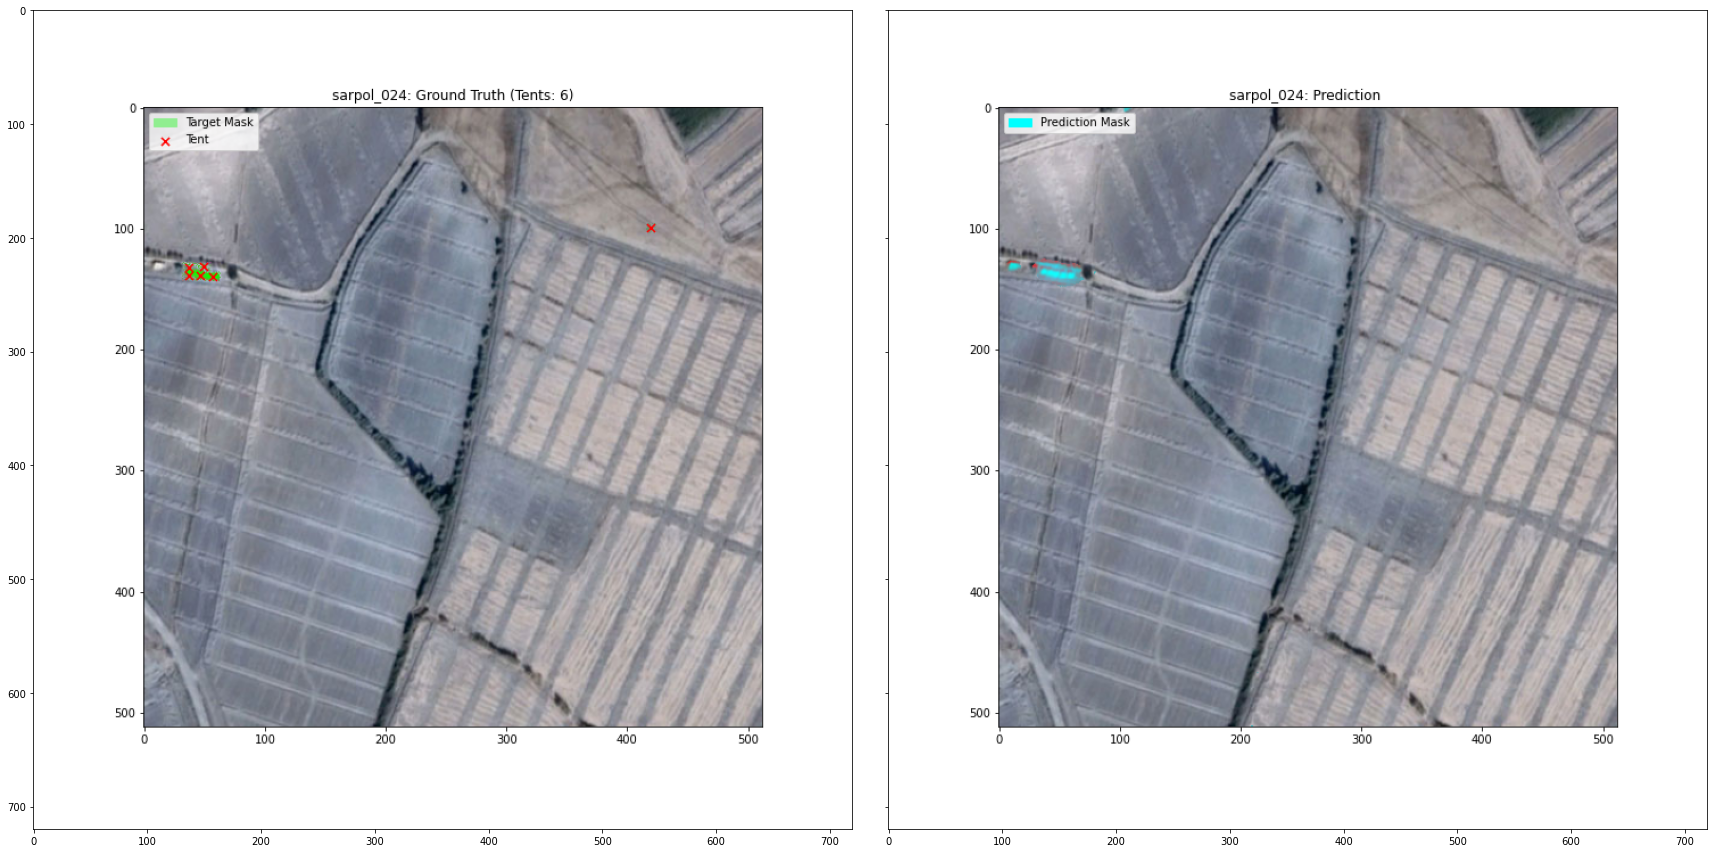


Loading: sarpol_032


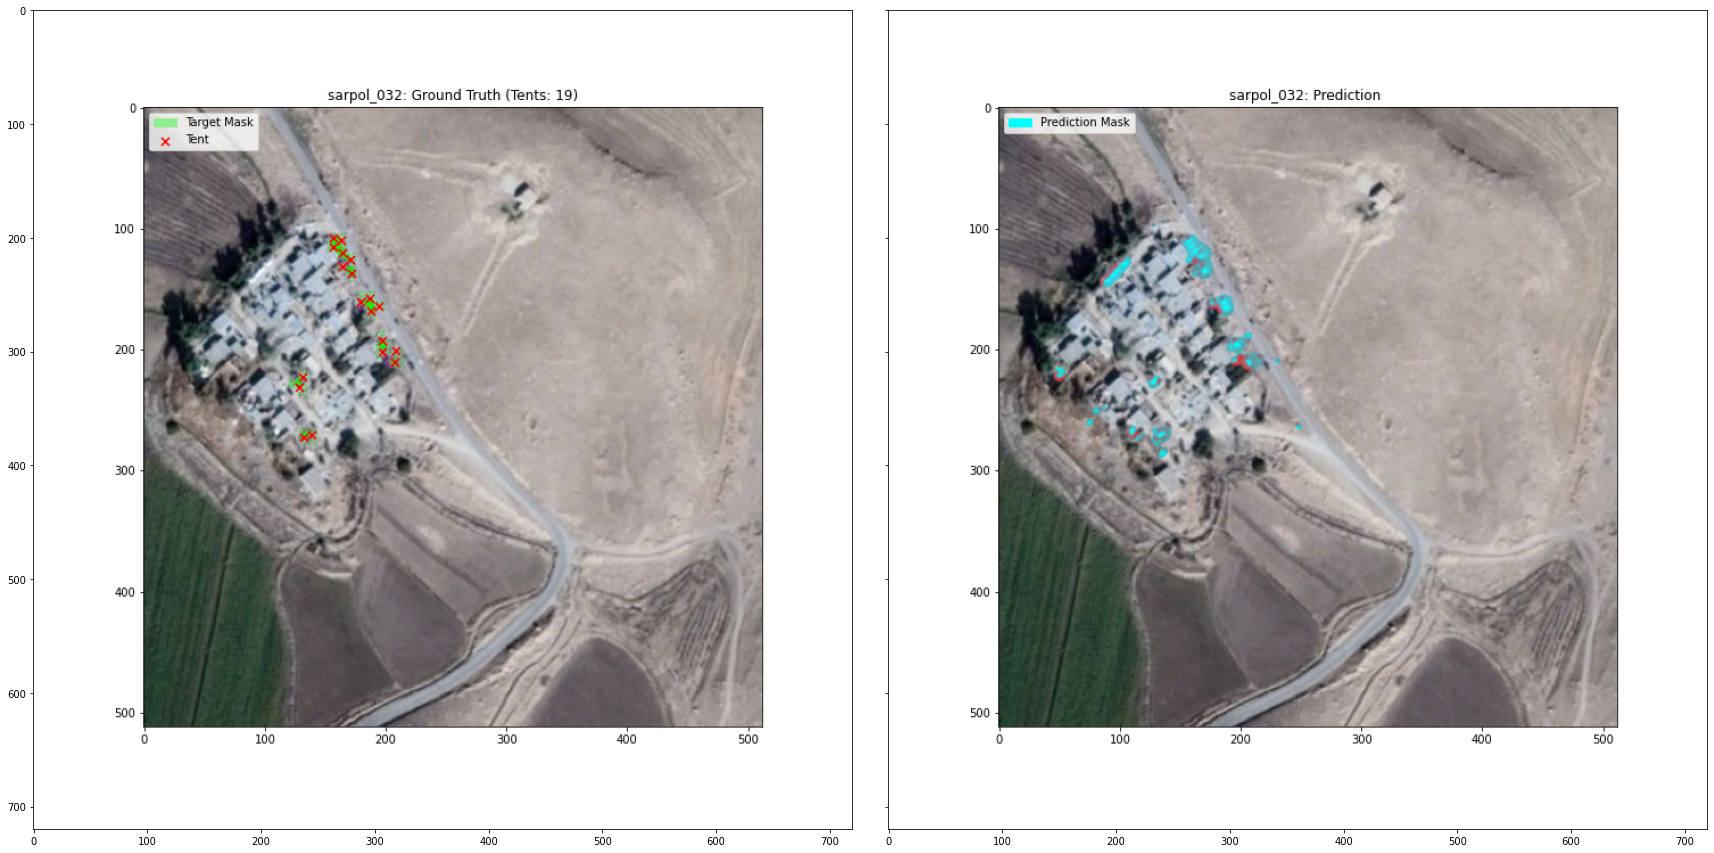


Loading: sarpol_072


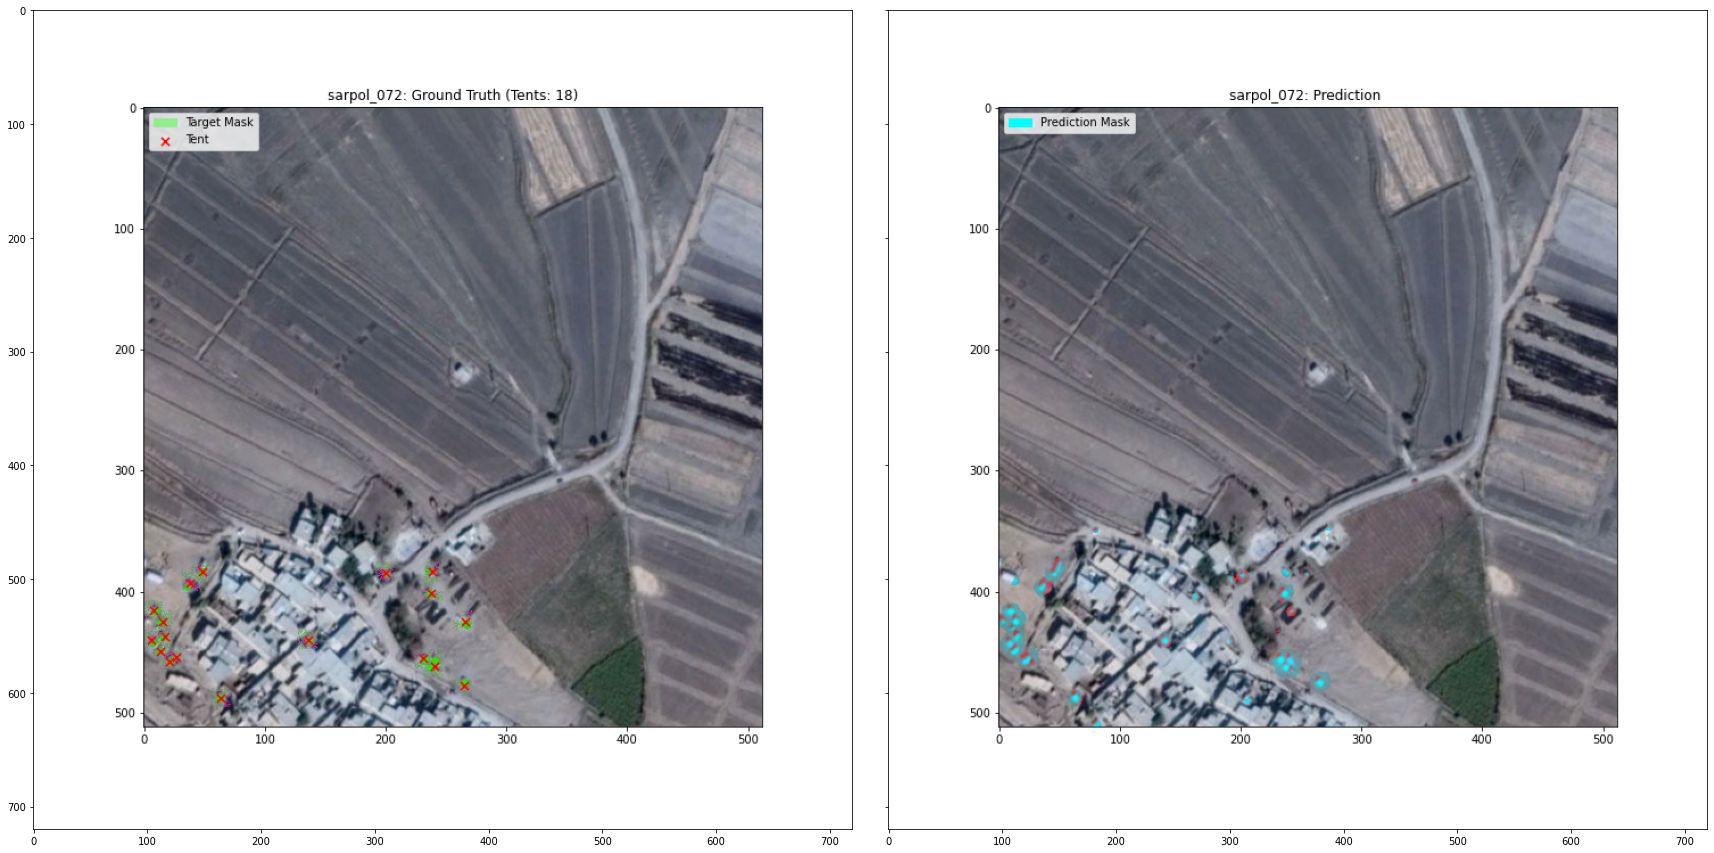


Loading: sarpol_083


In [ ]:
if __name__ == "__main__":
  main()